In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats

import csv
import os

In [2]:
filename_info = 'THE_WHEEL_12_31_2019_CHESTFINALSUBJECTS.xls'

pt_info = pd.read_excel(filename_info)
pt_info['label'] = pt_info['Group_Arb2'].map({0: 'control',
                                              1: 'pah',
                                              5: 'epah'})
pt_info['SID'] = pt_info['SID'].astype(str).str.zfill(3)

label_dict = dict(zip(pt_info['SID'].to_list(), pt_info['label'].to_list()))
# label_dict

### Pruned BV5 Data ("thresholded_results")

FD data are represented as % of BV5 artificially pruned, or thresholded, smallest vessels first.

In [54]:
# Compile all spreadsheets in relevant folder

old_folder = 'thresholded_results'
filters_include = ['_fd']
filters_exclude = ['-checkpoint', 'Visual']
extension = 'csv'

search_dir = os.path.join(os.getcwd(), old_folder)

print(f'Performing search in:\n{search_dir}\n')

csvFile_list = []
for root, dirs_list, files_list in os.walk(search_dir):
    for file_name in files_list:
        if file_name[-3:] == extension and \
        all([f in root or f in file_name for f in filters_include]) and \
        not any([f in root or f in file_name for f in filters_exclude]):
            file_name_path = os.path.join(root, file_name)
            csvFile_list.append(file_name_path)

sid_list = pt_info['SID'].to_list()

csvFile_list = [csvFile for csvFile in csvFile_list
                if any(sid == csvFile.split('\\')[-1][:3] for sid in sid_list)]

print(f'Compiled {len(csvFile_list)} files!')

Performing search in:
C:\Users\andre\Documents\github\fd_analysis\thresholded_results

Compiled 273 files!


In [16]:
# Compile Thresholded Data

# lobe_list = ['left', 'right', 'whole']
lobe_list = ['whole']
# artvein_list = ['']
# offset_list = ['']

for lobe in lobe_list:
    df_list = []
    for sid in sid_list:
        df_dict = {
            'SID':             sid,
            'lobe':            lobe,
            'label':           label_dict[sid],
        }
        files_matching = csvFile_list

        # Check for sid and lobe matching in file namee
        files_matching = [csvFile for csvFile in files_matching
                              if sid == csvFile.split('\\')[-1][:3] and \
                                 lobe in csvFile.split('\\')[-1]]

        for f in files_matching:
            try:
                with open(f) as csv_file:
                    csv_reader = csv.reader(csv_file)
                    csv_data = list(csv_reader)

                folder = f.split('\\')[-2]
                
                arr = np.asarray(csv_data[1:]).astype(float)

                for row in arr:
                    df_dict[f'{folder}__{int(row[0])}%BV5_FD'] = float(row[1])
            except:
                print(f'ERROR:\n{f}\n')

        df_list.append(df_dict)
    calculated_features = pd.DataFrame(df_list)
    calculated_features.to_csv(f'pruned_FDs.csv', index=False)

### Statistics

In [52]:
group = ['control', 'pah']
# features = [
#     'thresholded_results__0%BV5_FD',
#     'thresholded_results__50%BV5_FD',
#     'thresholded_results__100%BV5_FD',
# ]

percent_threshold_values = np.arange(0, 105, 5)
features = [f'thresholded_results__{x}%BV5_FD' for x in percent_threshold_values]

df_list = []
for i, feature in enumerate(features):
    X1 = calculated_features[calculated_features['label'].eq(group[0])][feature]
    X2 = calculated_features[calculated_features['label'].eq(group[1])][feature]

    _, pvalue = stats.mannwhitneyu(X1, X2)
    
    df_dict = {
        '% Pruning':           percent_threshold_values[i],
        f'{group[0]}_count':   len(X1),
        f'{group[0]}_median':  np.median(X1),
        f'{group[1]}_count':   len(X2),
        f'{group[1]}_median':  np.median(X2),
        'Wilcoxon p value':    pvalue,
    }
    
    df_list.append(df_dict)

df_stats = pd.DataFrame(df_list)
df_stats.to_csv(f'analysis_BV5Pruning.csv', index=False)

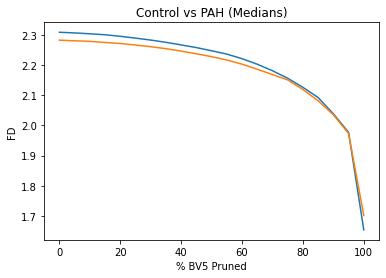

In [53]:
# plt.plot(percent_threshold_values, df_stats['p value'])
plt.plot(percent_threshold_values, df_stats['control_median'])
plt.plot(percent_threshold_values, df_stats['pah_median'])

plt.title('Control vs PAH (Medians)')
plt.xlabel('% BV5 Pruned')
plt.ylabel('FD');

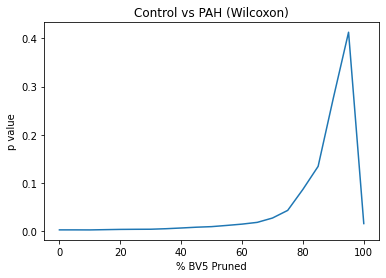

In [46]:
plt.plot(percent_threshold_values, df_stats['p value'])

plt.title('Control vs PAH (Wilcoxon)')
plt.xlabel('% BV5 Pruned')
plt.ylabel('p value');